# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=75,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_18-36-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4578 | MulticlassF1Score=0.1471
Batch-30 : CrossEntropyLoss=2.4686 | MulticlassF1Score=0.2055
Batch-45 : CrossEntropyLoss=2.4689 | MulticlassF1Score=0.2550
Batch-60 : CrossEntropyLoss=2.4074 | MulticlassF1Score=0.3045
Batch-75 : CrossEntropyLoss=2.3459 | MulticlassF1Score=0.3578
Batch-90 : CrossEntropyLoss=2.3647 | MulticlassF1Score=0.4076
Batch-105: CrossEntropyLoss=2.3714 | MulticlassF1Score=0.4438
Batch-120: CrossEntropyLoss=2.3336 | MulticlassF1Score=0.4727
Batch-135: CrossEntropyLoss=2.3369 | MulticlassF1Score=0.4941
Batch-150: CrossEntropyLoss=2.3649 | MulticlassF1Score=0.5108
Batch-165: CrossEntropyLoss=2.3574 | MulticlassF1Score=0.5257
Batch-180: CrossEntropyLoss=2.3485 | MulticlassF1Score=0.5375
Batch-195: CrossEntropyLoss=2.3511 | MulticlassF1Score=0.5482
Batch-210: CrossEntropyLoss=2.3446 | MulticlassF1Score=0.5574
Batch-225: CrossEntropyLoss=2.3373 | MulticlassF1Score=0.5667
Batch-226: CrossEntropyLoss=2.3439 | MulticlassF1Score=0.5672

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3408 | MulticlassF1Score=0.7154
Batch-30 : CrossEntropyLoss=2.3404 | MulticlassF1Score=0.7149
Batch-45 : CrossEntropyLoss=2.3300 | MulticlassF1Score=0.7114
Batch-60 : CrossEntropyLoss=2.3197 | MulticlassF1Score=0.7129
Batch-63 : CrossEntropyLoss=2.3425 | MulticlassF1Score=0.7134

Training   : Mean CrossEntropyLoss = 2.3920 | Mean MulticlassF1Score = 0.4076
Validation : Mean CrossEntropyLoss = 2.3387 | Mean MulticlassF1Score = 0.7157

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3332 | MulticlassF1Score=0.7220
Batch-30 : CrossEntropyLoss=2.3397 | MulticlassF1Score=0.7260
Batch-45 : CrossEntropyLoss=2.3177 | MulticlassF1Score=0.7354
Batch-60 : CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7475
Batch-75 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.7531
Batch-90 : CrossEntropyLoss=2.3199 | MulticlassF1Score=0.7596
Batch-105: CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7630
Batch-120: CrossEntropyLoss=2.3202 | MulticlassF1Score=0.7658
Batch-135: CrossEntropyLoss=2.3109 | MulticlassF1Score=0.7682
Batch-150: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7707
Batch-165: CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7727
Batch-180: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.7743
Batch-195: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.7760
Batch-210: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7772
Batch-225: CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7783
Batch-226: CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7784

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.7924
Batch-30 : CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7941
Batch-45 : CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7942
Batch-60 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.7918
Batch-63 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.7922

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3175 | Mean MulticlassF1Score = 0.7576
Validation : Mean CrossEntropyLoss = 2.3131 | Mean MulticlassF1Score = 0.7928

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.7944
Batch-30 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7943
Batch-45 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.7941
Batch-60 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.7947
Batch-75 : CrossEntropyLoss=2.3177 | MulticlassF1Score=0.7955
Batch-90 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.7934
Batch-105: CrossEntropyLoss=2.3166 | MulticlassF1Score=0.7933
Batch-120: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.7939
Batch-135: CrossEntropyLoss=2.3271 | MulticlassF1Score=0.7940
Batch-150: CrossEntropyLoss=2.3169 | MulticlassF1Score=0.7940
Batch-165: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.7939
Batch-180: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7939
Batch-195: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.7941
Batch-210: CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7947
Batch-225: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7951
Batch-226: CrossEntropyLoss=2.3157 | MulticlassF1Score=0.7950

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3119 | MulticlassF1Score=0.7903
Batch-30 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7903
Batch-45 : CrossEntropyLoss=2.3160 | MulticlassF1Score=0.7932
Batch-60 : CrossEntropyLoss=2.3239 | MulticlassF1Score=0.7953
Batch-63 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.7951

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3114 | Mean MulticlassF1Score = 0.7941
Validation : Mean CrossEntropyLoss = 2.3116 | Mean MulticlassF1Score = 0.7903

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3215 | MulticlassF1Score=0.7932
Batch-30 : CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7926
Batch-45 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.7949
Batch-60 : CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7953
Batch-75 : CrossEntropyLoss=2.3203 | MulticlassF1Score=0.7949
Batch-90 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.7967
Batch-105: CrossEntropyLoss=2.3127 | MulticlassF1Score=0.7974
Batch-120: CrossEntropyLoss=2.3198 | MulticlassF1Score=0.7977
Batch-135: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.7984
Batch-150: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7995
Batch-165: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8015
Batch-180: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8039
Batch-195: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8057
Batch-210: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8072
Batch-225: CrossEntropyLoss=2.3187 | MulticlassF1Score=0.8083
Batch-226: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8084

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3152 | MulticlassF1Score=0.8181
Batch-30 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8227
Batch-45 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8218
Batch-60 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8228
Batch-63 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8226

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3071 | Mean MulticlassF1Score = 0.7988
Validation : Mean CrossEntropyLoss = 2.3031 | Mean MulticlassF1Score = 0.8218

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8229
Batch-30 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8254
Batch-45 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8261
Batch-60 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8273
Batch-75 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8291
Batch-90 : CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8310
Batch-105: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8321
Batch-120: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8337
Batch-135: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8343
Batch-150: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8348
Batch-165: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8349
Batch-180: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8350
Batch-195: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8355
Batch-210: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8358
Batch-225: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8360
Batch-226: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8360

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8334
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8356
Batch-45 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8347
Batch-60 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8355
Batch-63 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8356

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2985 | Mean MulticlassF1Score = 0.8306
Validation : Mean CrossEntropyLoss = 2.2990 | Mean MulticlassF1Score = 0.8358

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8362
Batch-30 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8388
Batch-45 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8407
Batch-60 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8391
Batch-75 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8396
Batch-90 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8399
Batch-105: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8396
Batch-120: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8392
Batch-135: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8401
Batch-150: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8400
Batch-165: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8404
Batch-180: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8407
Batch-195: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8403
Batch-210: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8399
Batch-225: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8401
Batch-226: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8401

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8375
Batch-30 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8394
Batch-45 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8386
Batch-60 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8370
Batch-63 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8367

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2971 | Mean MulticlassF1Score = 0.8394
Validation : Mean CrossEntropyLoss = 2.2987 | Mean MulticlassF1Score = 0.8369

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8356
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8360
Batch-45 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8390
Batch-60 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8402
Batch-75 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8398
Batch-90 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8407
Batch-105: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8403
Batch-120: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8406
Batch-135: CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8412
Batch-150: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8409
Batch-165: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8415
Batch-180: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8426
Batch-195: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8438
Batch-210: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8448
Batch-225: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8457
Batch-226: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8457

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8542
Batch-30 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8513
Batch-45 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8513
Batch-60 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8518
Batch-63 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8521

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2955 | Mean MulticlassF1Score = 0.8405
Validation : Mean CrossEntropyLoss = 2.2941 | Mean MulticlassF1Score = 0.8519

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8570
Batch-30 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8589
Batch-45 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8600
Batch-60 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8585
Batch-75 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8572
Batch-90 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8570
Batch-105: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8575
Batch-120: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8576
Batch-135: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8580
Batch-150: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8584
Batch-165: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8583
Batch-180: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8581
Batch-195: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8583
Batch-210: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8586
Batch-225: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8587
Batch-226: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8586

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8545
Batch-30 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8540
Batch-45 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8546
Batch-60 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8543
Batch-63 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8542

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2916 | Mean MulticlassF1Score = 0.8580
Validation : Mean CrossEntropyLoss = 2.2932 | Mean MulticlassF1Score = 0.8544

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8638
Batch-30 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8594
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8631
Batch-60 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8621
Batch-75 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8612
Batch-90 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8606
Batch-105: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8603
Batch-120: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8607
Batch-135: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8604
Batch-150: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8601
Batch-165: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8598
Batch-180: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8596
Batch-195: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8594
Batch-210: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8599
Batch-225: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8612
Batch-226: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8612

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8707
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8746
Batch-45 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8758
Batch-60 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8757
Batch-63 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8758

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2906 | Mean MulticlassF1Score = 0.8607
Validation : Mean CrossEntropyLoss = 2.2871 | Mean MulticlassF1Score = 0.8743

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8807
Batch-30 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8842
Batch-45 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8862
Batch-60 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8861
Batch-75 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8876
Batch-90 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8877
Batch-105: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8869
Batch-120: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8869
Batch-135: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8870
Batch-150: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8876
Batch-165: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8877
Batch-180: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8880
Batch-195: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8877
Batch-210: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8873
Batch-225: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8874
Batch-226: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8873

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8855
Batch-30 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8841
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8844
Batch-60 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8836
Batch-63 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8836

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8867
Validation : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8842

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8874
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8895
Batch-45 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8885
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8883
Batch-75 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8892
Batch-90 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8905
Batch-105: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8918
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8914
Batch-135: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8915
Batch-150: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8916
Batch-165: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8916
Batch-180: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.8915
Batch-195: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8915
Batch-210: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8915
Batch-225: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8916
Batch-226: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8916

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8848
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8861
Batch-45 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8852
Batch-60 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8848
Batch-63 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8846

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8902
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8856

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8945
Batch-30 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8940
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8935
Batch-60 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8945
Batch-75 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.8940
Batch-90 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8951
Batch-105: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8957
Batch-120: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8955
Batch-135: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8951
Batch-150: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8946
Batch-165: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8945
Batch-180: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8944
Batch-195: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8942
Batch-210: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8945
Batch-225: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8945
Batch-226: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8945

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8864
Batch-30 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8871
Batch-45 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8878
Batch-60 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8867
Batch-63 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8860

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8944
Validation : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8873

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.8974
Batch-30 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8979
Batch-45 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8987
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8982
Batch-75 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8983
Batch-90 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8980
Batch-105: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8972
Batch-120: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8966
Batch-135: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8967
Batch-150: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8966
Batch-165: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8967
Batch-180: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8969
Batch-195: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8969
Batch-210: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.8969
Batch-225: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8967
Batch-226: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8967

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8806
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8839
Batch-45 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8851
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8849
Batch-63 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8848

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2797 | Mean MulticlassF1Score = 0.8976
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8837

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8938
Batch-30 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8969
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8967
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.8972
Batch-75 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8980
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8984
Batch-105: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8977
Batch-120: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8974
Batch-135: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8976
Batch-150: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8971
Batch-165: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8975
Batch-180: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8971
Batch-195: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8974
Batch-210: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8977
Batch-225: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8975
Batch-226: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8975

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8869
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8849
Batch-45 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8879
Batch-60 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8864
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8866

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2794 | Mean MulticlassF1Score = 0.8971
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8870

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8982
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.8972
Batch-45 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8991
Batch-60 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8989
Batch-75 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8989
Batch-90 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8994
Batch-105: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8993
Batch-120: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8991
Batch-135: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8988
Batch-150: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8987
Batch-165: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8995
Batch-180: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.8992
Batch-195: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8991
Batch-210: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.8990
Batch-225: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8992
Batch-226: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8991

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8857
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8867
Batch-45 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8853
Batch-60 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8867
Batch-63 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8865

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2788 | Mean MulticlassF1Score = 0.8992
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8872

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9000
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9016
Batch-45 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9008
Batch-60 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.9001
Batch-75 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9004
Batch-90 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8998
Batch-105: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8998
Batch-120: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9003
Batch-135: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9005
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9008
Batch-165: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.9006
Batch-180: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9008
Batch-195: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9004
Batch-210: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9006
Batch-225: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9004
Batch-226: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9004

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8845
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8873
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8895
Batch-60 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8900
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8896

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2783 | Mean MulticlassF1Score = 0.9005
Validation : Mean CrossEntropyLoss = 2.2821 | Mean MulticlassF1Score = 0.8873

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9046
Batch-30 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9039
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9045
Batch-60 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9043
Batch-75 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9047
Batch-90 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9048
Batch-105: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9040
Batch-120: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9040
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9051
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9077
Batch-165: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9096
Batch-180: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9106
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9120
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9128
Batch-225: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9138
Batch-226: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9139

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9185
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9172
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9161
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9167
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9167

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9068
Validation : Mean CrossEntropyLoss = 2.2739 | Mean MulticlassF1Score = 0.9174

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9326
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9345
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9335
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9329
Batch-75 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9327
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9324
Batch-105: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9327
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9326
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9327
Batch-150: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9328
Batch-165: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9328
Batch-180: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9329
Batch-195: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9331
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9332
Batch-225: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9332
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9333

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9211
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9221
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9212
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9208
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9210

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9327
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9216

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9308
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9325
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9328
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9339
Batch-75 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9342
Batch-90 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9347
Batch-105: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9355
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9355
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9360
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9358
Batch-165: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9357
Batch-180: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9355
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9355
Batch-210: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9352
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9354
Batch-226: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9354

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9224
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9221
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9215
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9216

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9345
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9221

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9378
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9383
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9384
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9386
Batch-90 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9377
Batch-105: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9379
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9381
Batch-135: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9378
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9372
Batch-165: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9369
Batch-180: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9367
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9368
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9367
Batch-225: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9368
Batch-226: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9367

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9217
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9226
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9217
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9382
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9226

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9373
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9370
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9371
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9362
Batch-75 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9367
Batch-90 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9372
Batch-105: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9372
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9374
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9375
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9378
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9379
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9379
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9382
Batch-210: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9385
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9383
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9383

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9221
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9238
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9245
Batch-63 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9248

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9373
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9234

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9401
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9410
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9422
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9419
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9425
Batch-105: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9419
Batch-120: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9420
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9424
Batch-150: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9419
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9420
Batch-180: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9418
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9416
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9411
Batch-226: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9252
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9253

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9418
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9238

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9436
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9429
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9424
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9423
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9421
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9424
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9427
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9425
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9422
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9420
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9418
Batch-225: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9418
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9418

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9295
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9272
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9240

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9428
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9268

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9425
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9425
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9422
Batch-90 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9422
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9420
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9424
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9428
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9423
Batch-165: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9425
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9424
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9424
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9423
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9422
Batch-226: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9422

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9279
Batch-30 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9427
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9256

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9432
Batch-75 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9433
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9428
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9431
Batch-135: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9432
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9430
Batch-165: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9432
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9428
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9427
Batch-210: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9426
Batch-225: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9424
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9424

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9272
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9234
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9251
Batch-63 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9250

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9430
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9249

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9434
Batch-75 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9421
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9420
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9418
Batch-135: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9418
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9421
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9423
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9425
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9423
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9423
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9423

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9241
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9250
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9265

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9431
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9249
Patience = 1/50❗

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9391
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9426
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9430
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9429
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9431
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9436
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9435
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9435
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9431
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9431
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9430
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9428
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9238
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9425
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9248

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9418
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9405
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9422
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9422
Batch-90 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9423
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9426
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9424
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9427
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9431
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9431
Batch-180: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9428
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9426
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9428
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9430
Batch-226: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9430

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9260
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9253
Batch-63 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9423
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9266

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9444
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9450
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9448
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9447
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9447
Batch-120: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9445
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9440
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9440
Batch-165: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9438
Batch-180: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9435
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9433
Batch-226: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9434

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9237
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9265
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9262
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9253
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9444
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9244

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9431
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9444
Batch-75 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9438
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9441
Batch-105: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9439
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9444
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9444
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9444
Batch-195: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9443
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9440
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9441
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9244
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9254
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9266
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9438
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9251

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9440
Batch-75 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9438
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9434
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9433
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9437
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9438
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9440
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9439
Batch-225: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9441
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9261
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9258

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9437
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9257
Patience = 2/50❗

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9443
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9435
Batch-90 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9439
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9442
Batch-120: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9440
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9436
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9436
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9431
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9435
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9437
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9439
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9438
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9438

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9258

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9439
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9246
Patience = 3/50❗

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9497
Batch-90 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9516
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9531
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9546
Batch-135: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9554
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9563
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9570
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9575
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9580
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9582
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9585
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9584

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9453
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9451

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2604 | Mean MulticlassF1Score = 0.9522
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9449

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9632
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9645
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9651
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9643
Batch-75 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9641
Batch-90 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9643
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9638
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9635
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9633
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9634
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9631
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9632
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9631
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9630
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9633
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9632

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9637
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9472

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9674
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9664
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9661
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9652
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9650
Batch-90 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9644
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9640
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9641
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9641
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9642
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9642
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9644
Batch-195: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9644
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9643
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9642
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9642

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9459
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9463

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9652
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9464

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9667
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9652
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9660
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9656
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9655
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9653
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9654
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9651
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9648
Batch-165: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9647
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9648
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9648
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9649
Batch-225: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9648
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9647

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9654
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9455

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9684
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9661
Batch-60 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9660
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9659
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9653
Batch-105: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9659
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9659
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9658
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9655
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9652
Batch-180: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9651
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9650
Batch-225: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9649
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9649

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9460
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9458

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9661
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9465

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9621
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9638
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9641
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9641
Batch-75 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9643
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9648
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9653
Batch-120: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9653
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9655
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9654
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9654
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9655
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9654
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9654
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9653

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9469
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9646
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9463

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9647
Batch-30 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9657
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9653
Batch-60 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9650
Batch-75 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9653
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9653
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9653
Batch-135: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9654
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9654
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9657
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9658
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9656
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9467

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9652
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9462

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9675
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9661
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9659
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9662
Batch-90 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9658
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9656
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9655
Batch-135: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9656
Batch-150: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9655
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9656
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9658
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9659
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9661
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9661
Batch-226: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9660

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9508
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9497
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9660
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9494

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9668
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9669
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9671
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9669
Batch-120: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9669
Batch-135: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9673
Batch-180: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2515 | MulticlassF1Score=0.9677
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9674
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9674
Batch-226: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9506
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9488

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9675
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9680
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9689
Batch-90 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9687
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9483

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9673
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9668
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9667
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9682
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9683
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9683
Batch-225: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9488
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9486

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9469
Patience = 4/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9673
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9679
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9682
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9682
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9478

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9674
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9687
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9679
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9488
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9479

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9682
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9489
Patience = 5/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9676
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9676
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9677
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9675
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9488

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9657
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9673
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9682
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9488

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9706
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9689
Batch-90 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9687
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9689
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9495
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9693
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9484

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9694
Batch-30 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9701
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9717
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9693
Batch-135: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9697
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9698
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9698

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9698
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9468

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9718
Batch-30 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9711
Batch-45 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9717
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9711
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9701
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9699
Batch-180: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9698
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9698
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9698
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9697
Batch-226: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9697

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9533
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9512
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9487

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9499
Patience = 6/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2567
Best CrossEntropyLoss training    : 2.2634
Best MulticlassF1Score validation : 0.9698
Best MulticlassF1Score validation : 0.9468
Training duration                 : 2.0494 minutes.
Training date                     : 2022-10-19 13:00:46.789617+08:00


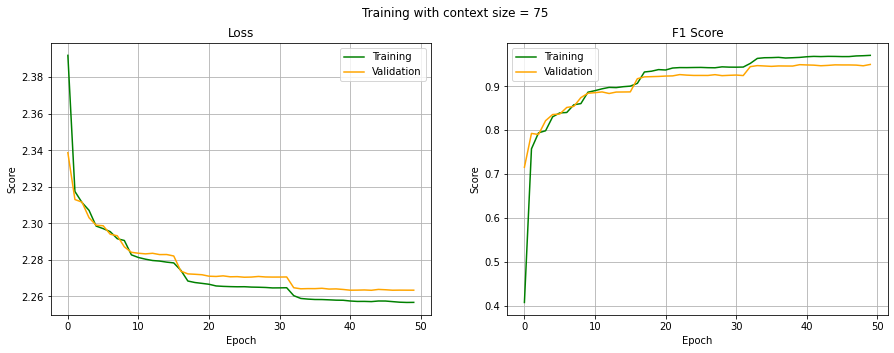

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9702, device='cuda:0'),
 tensor(0.9487, device='cuda:0'),
 tensor(0.9477, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9702, device='cuda:0'),
 tensor(0.9487, device='cuda:0'),
 tensor(0.9477, device='cuda:0'))

## Heatmap

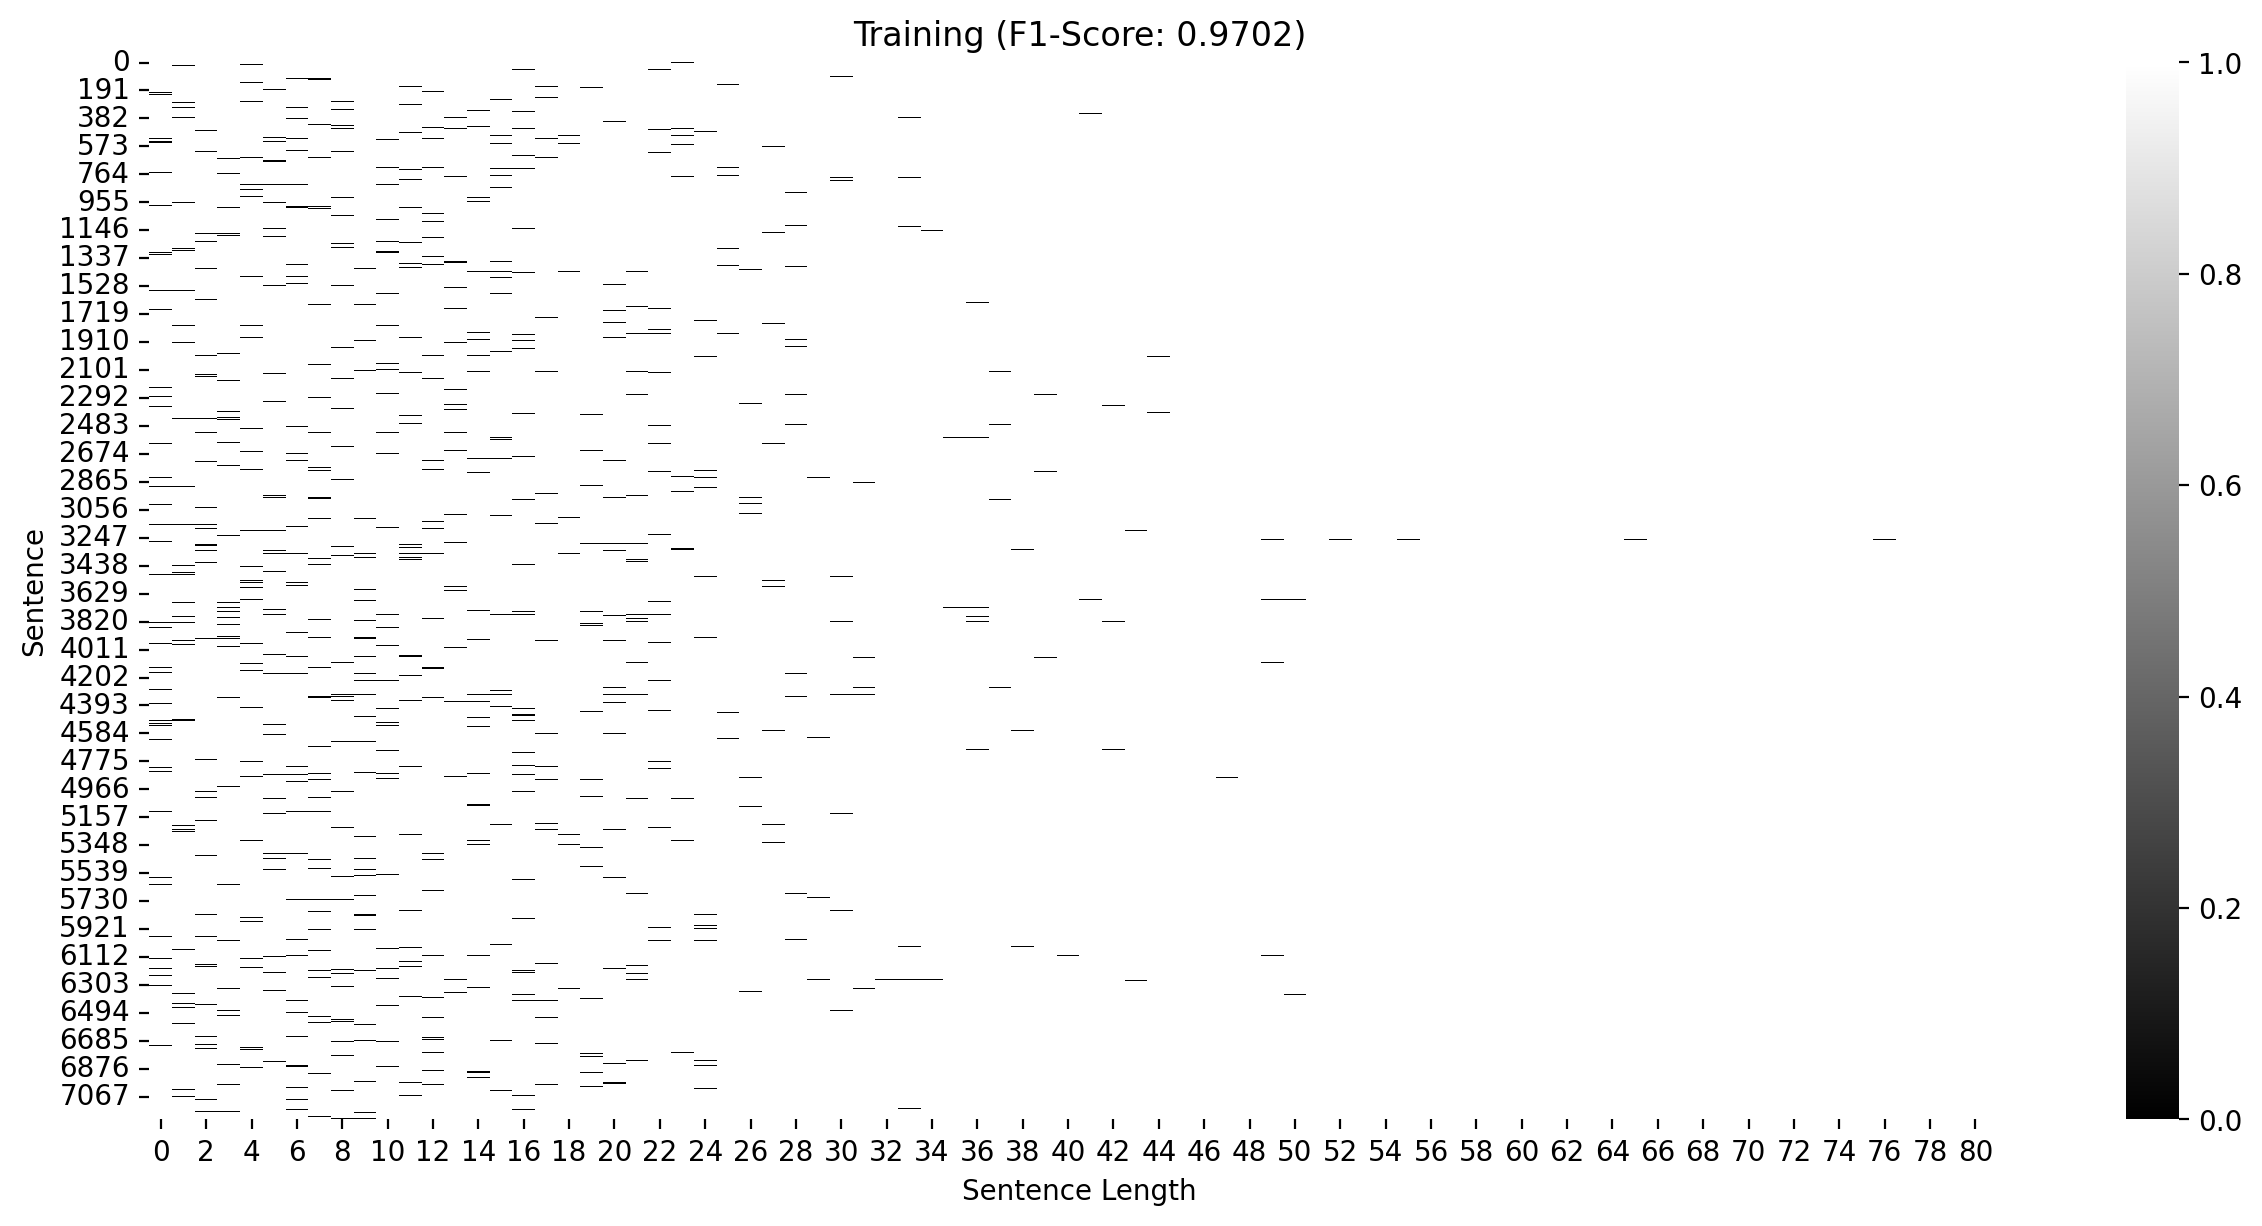

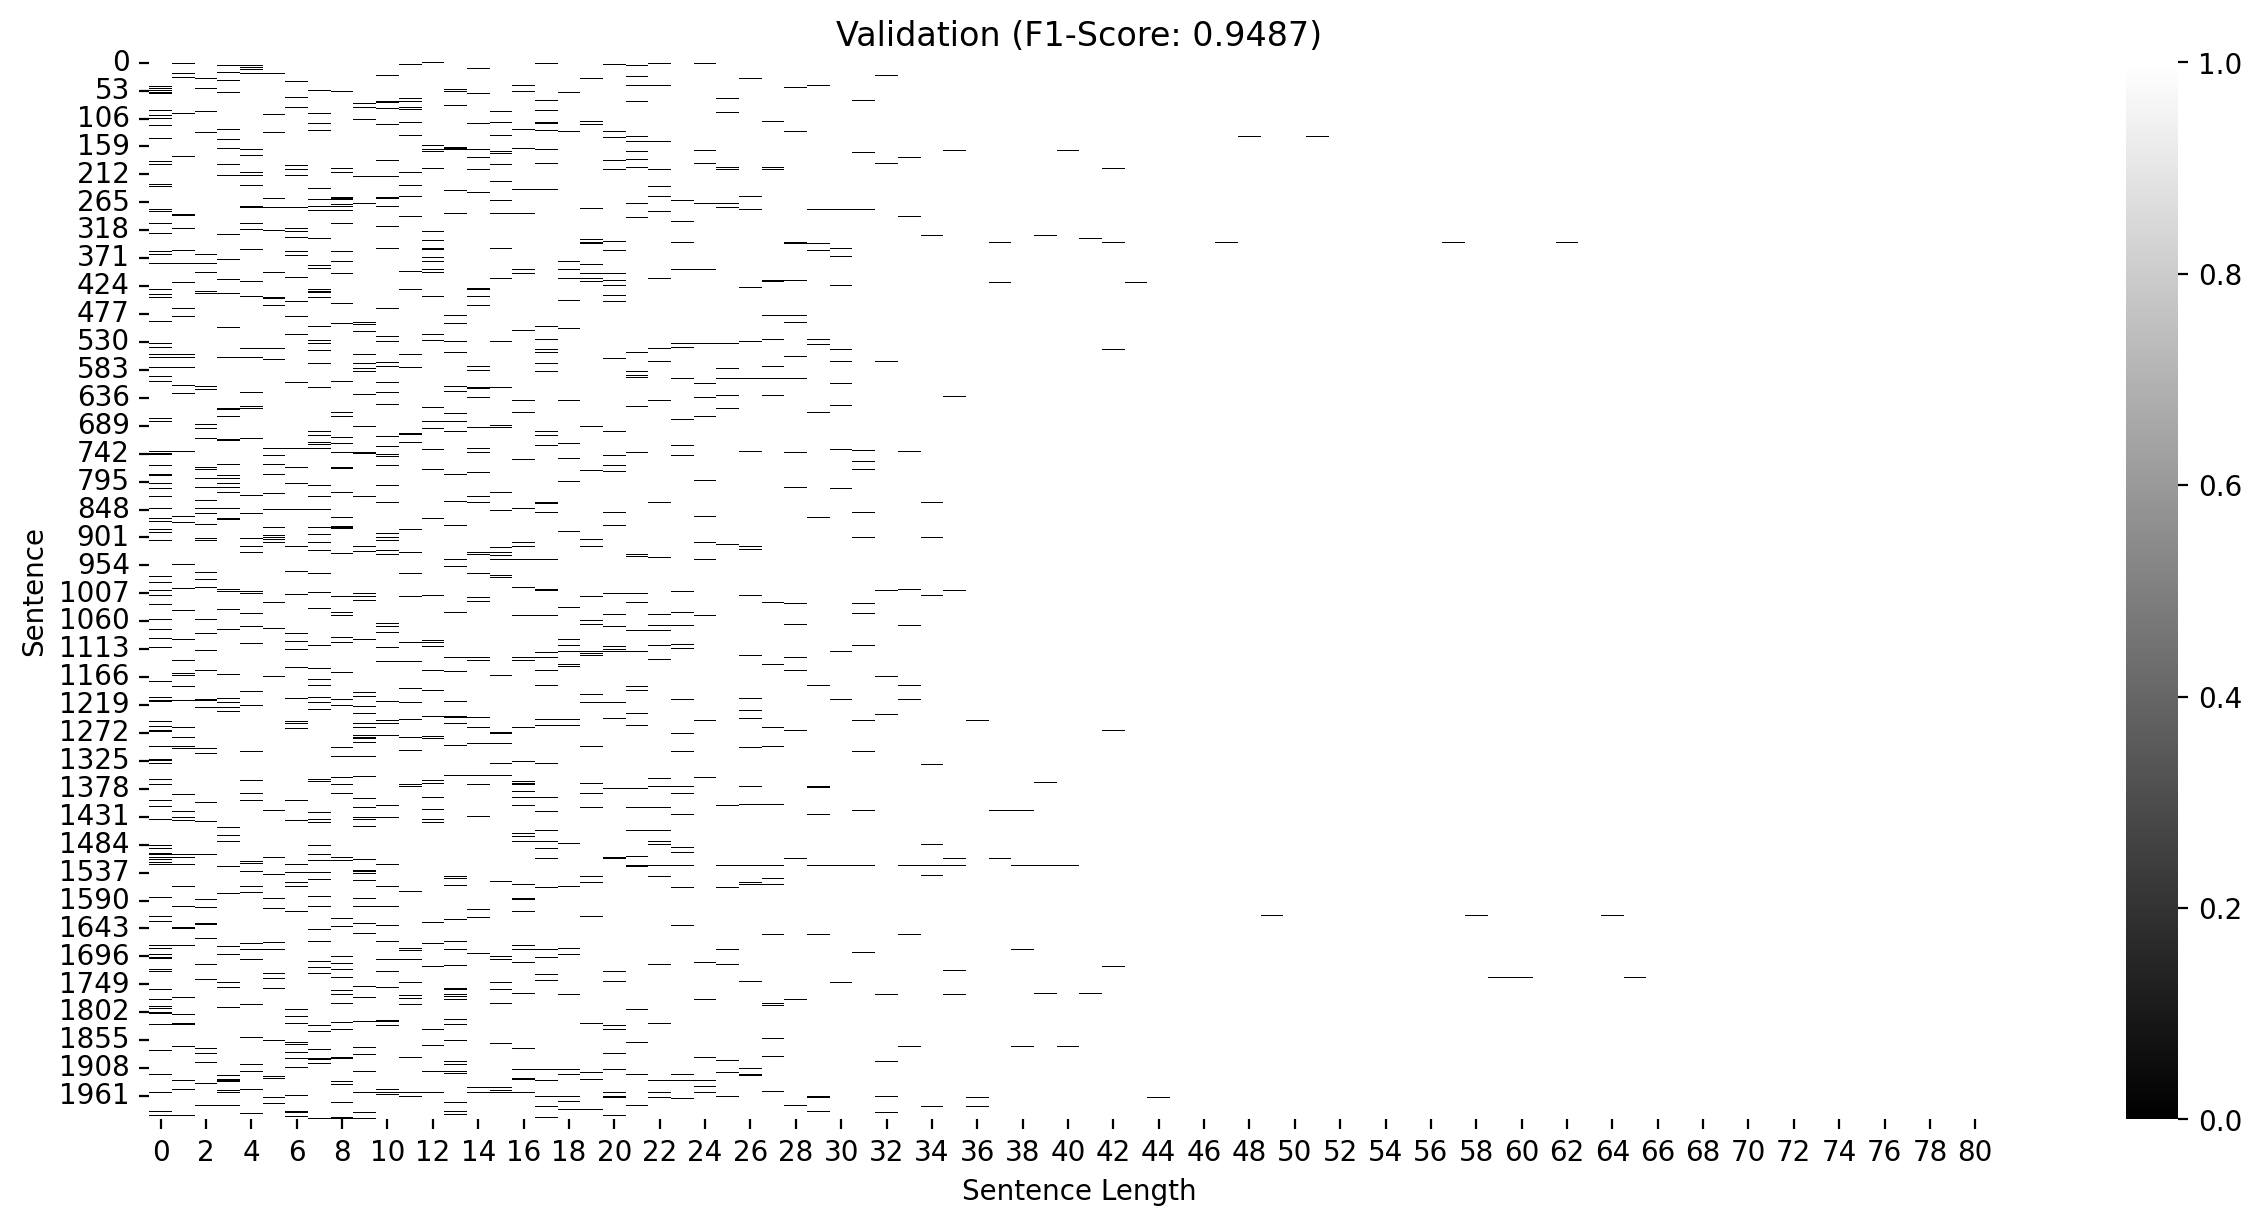

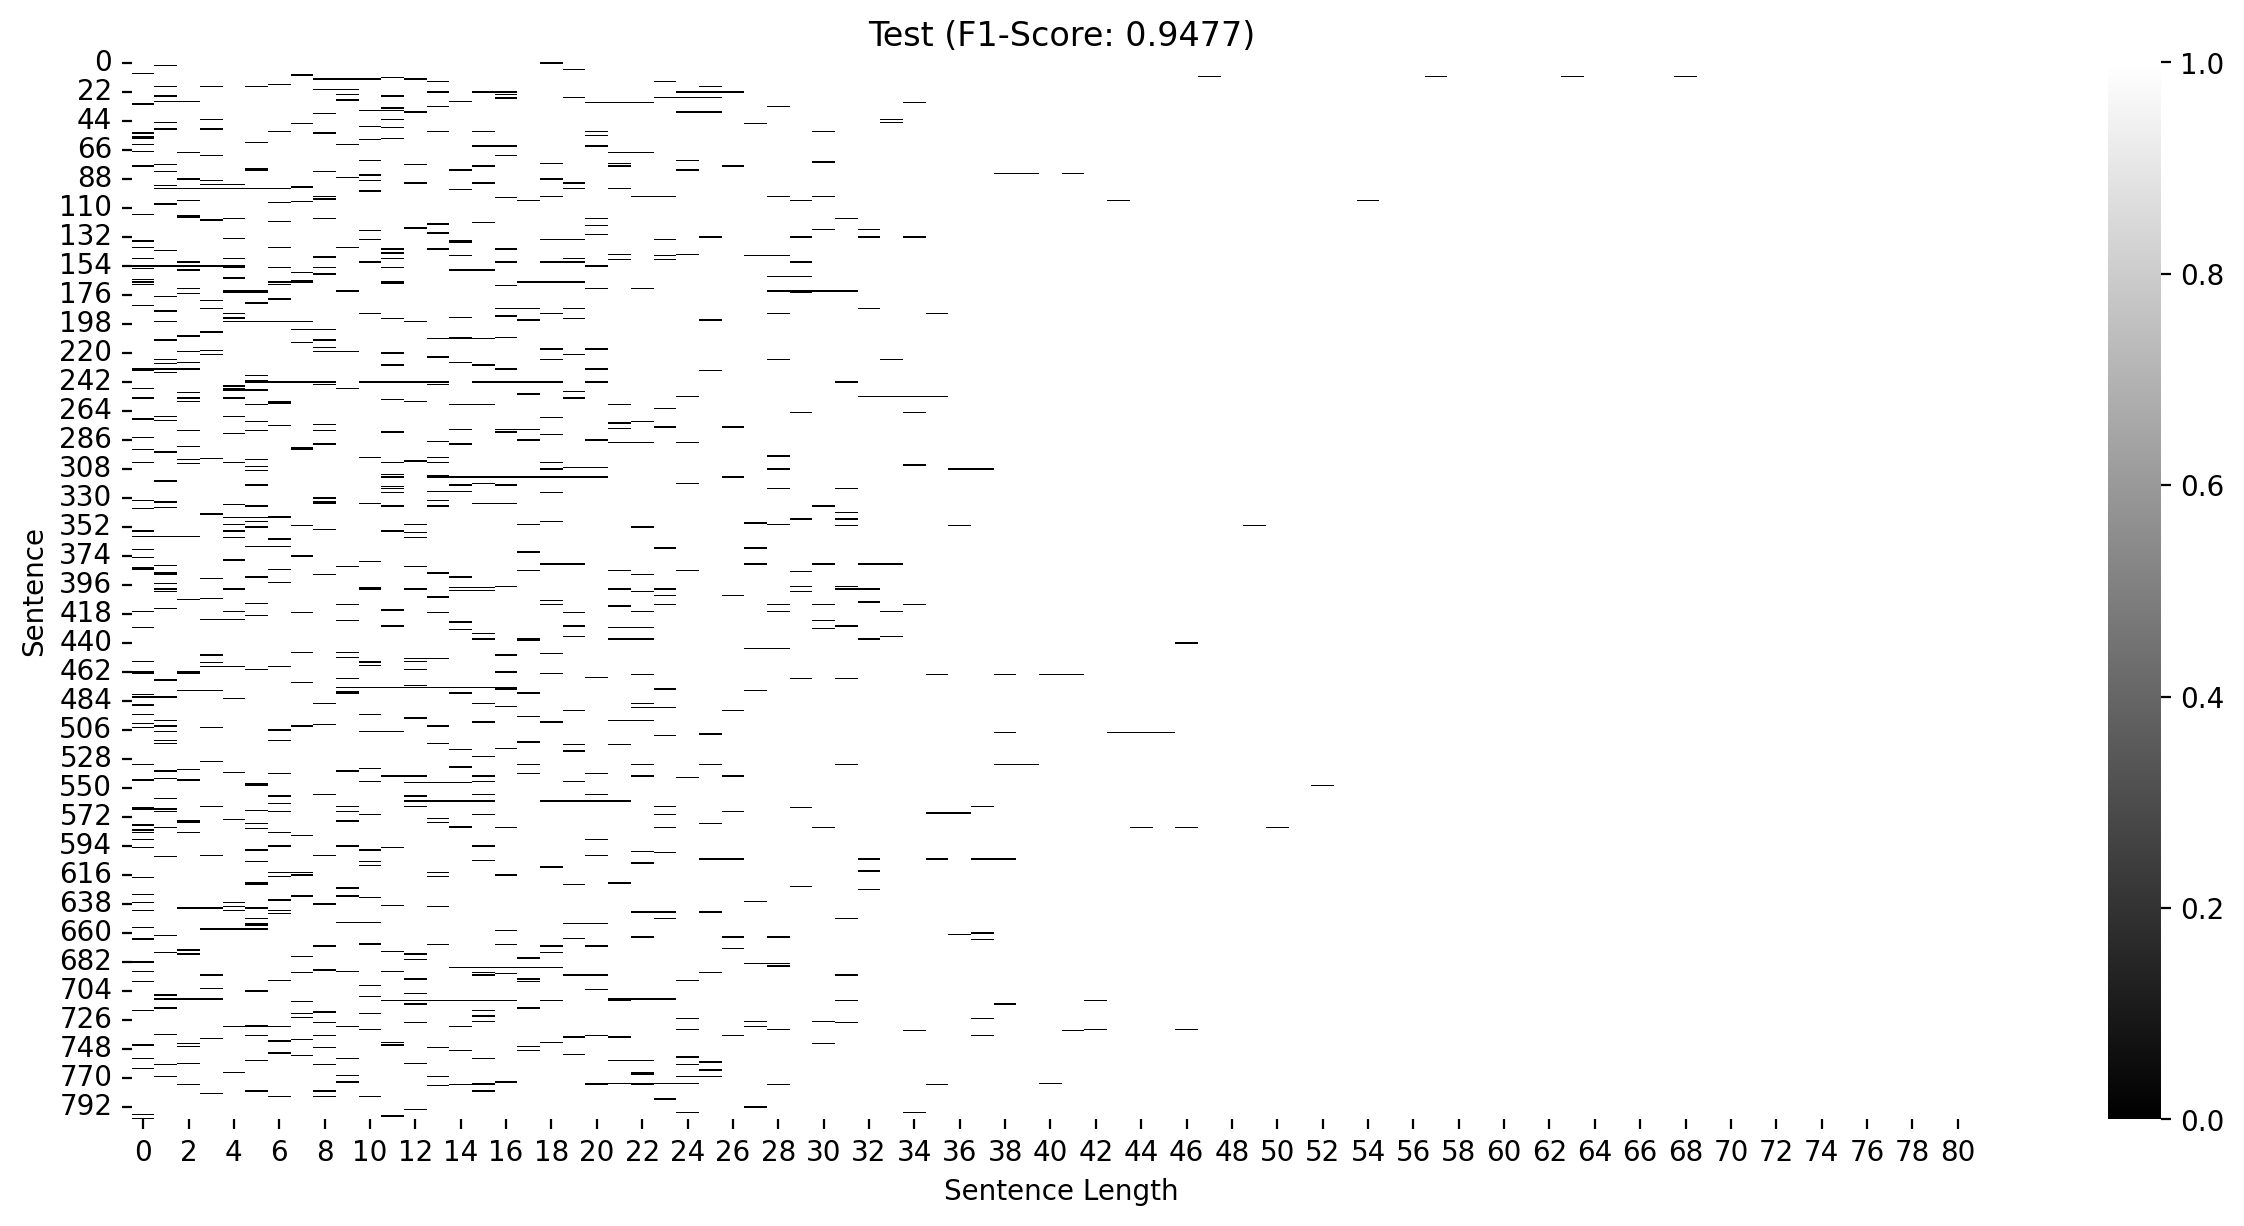

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


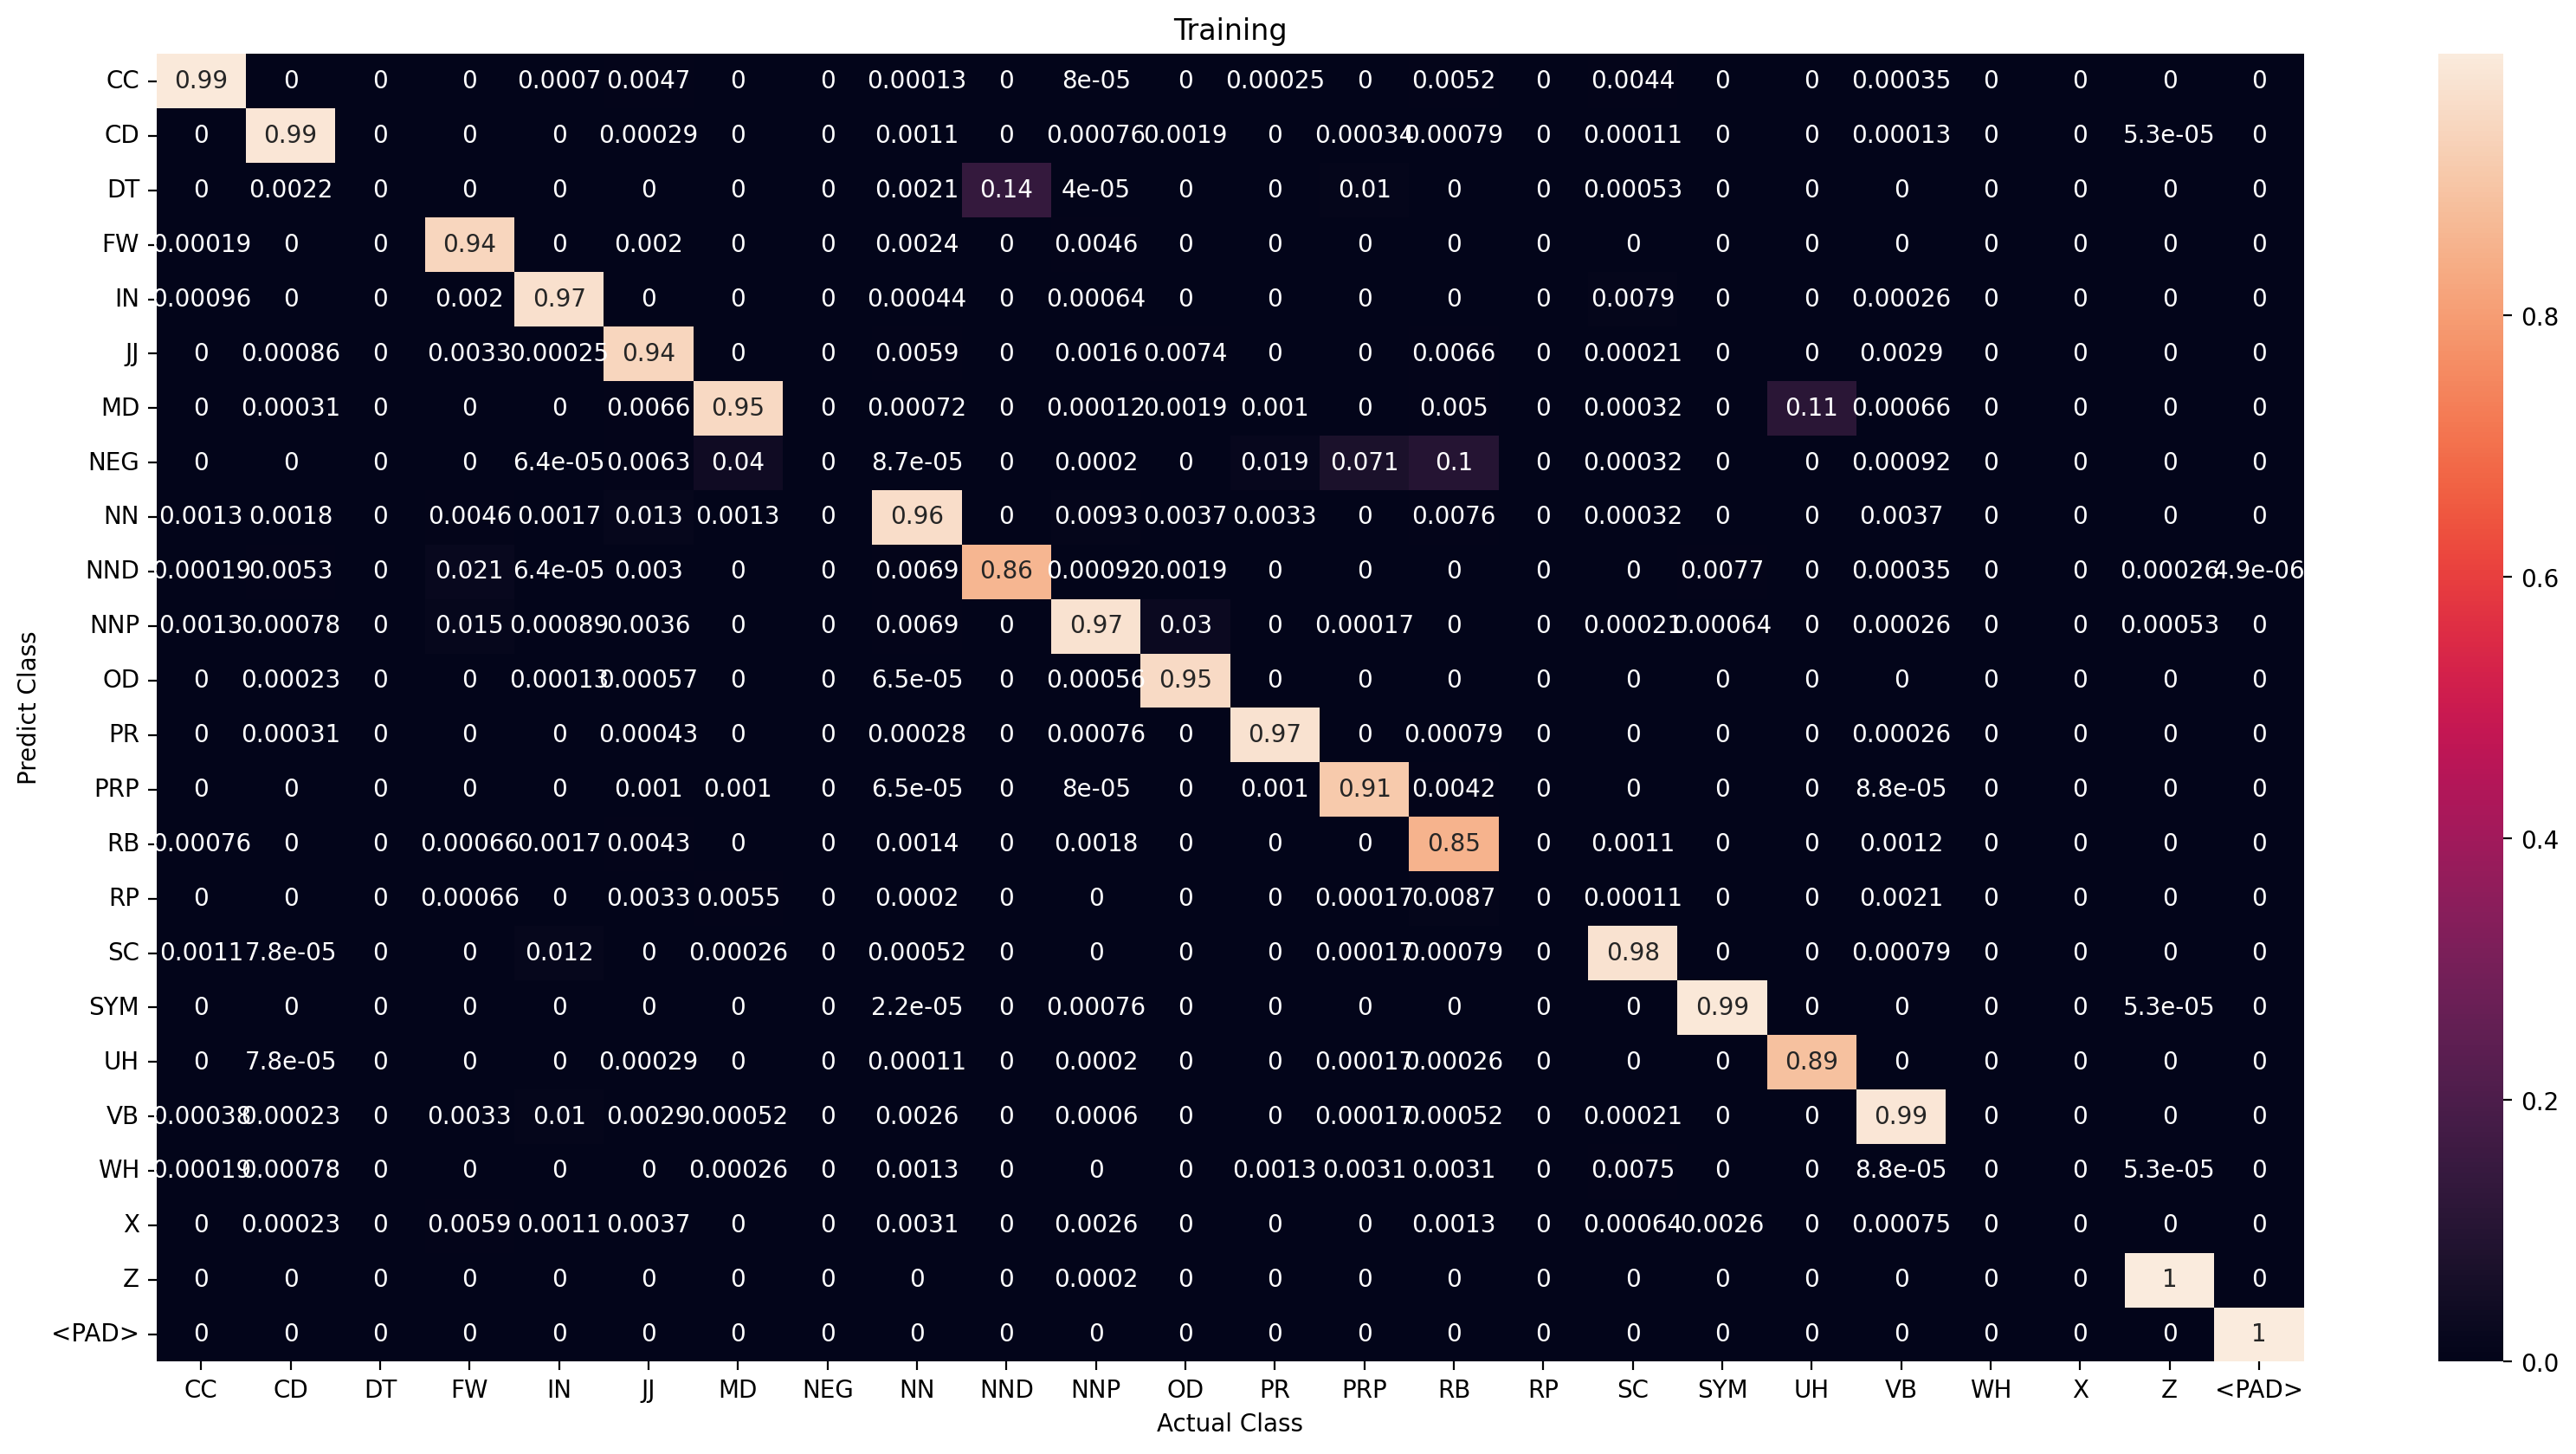

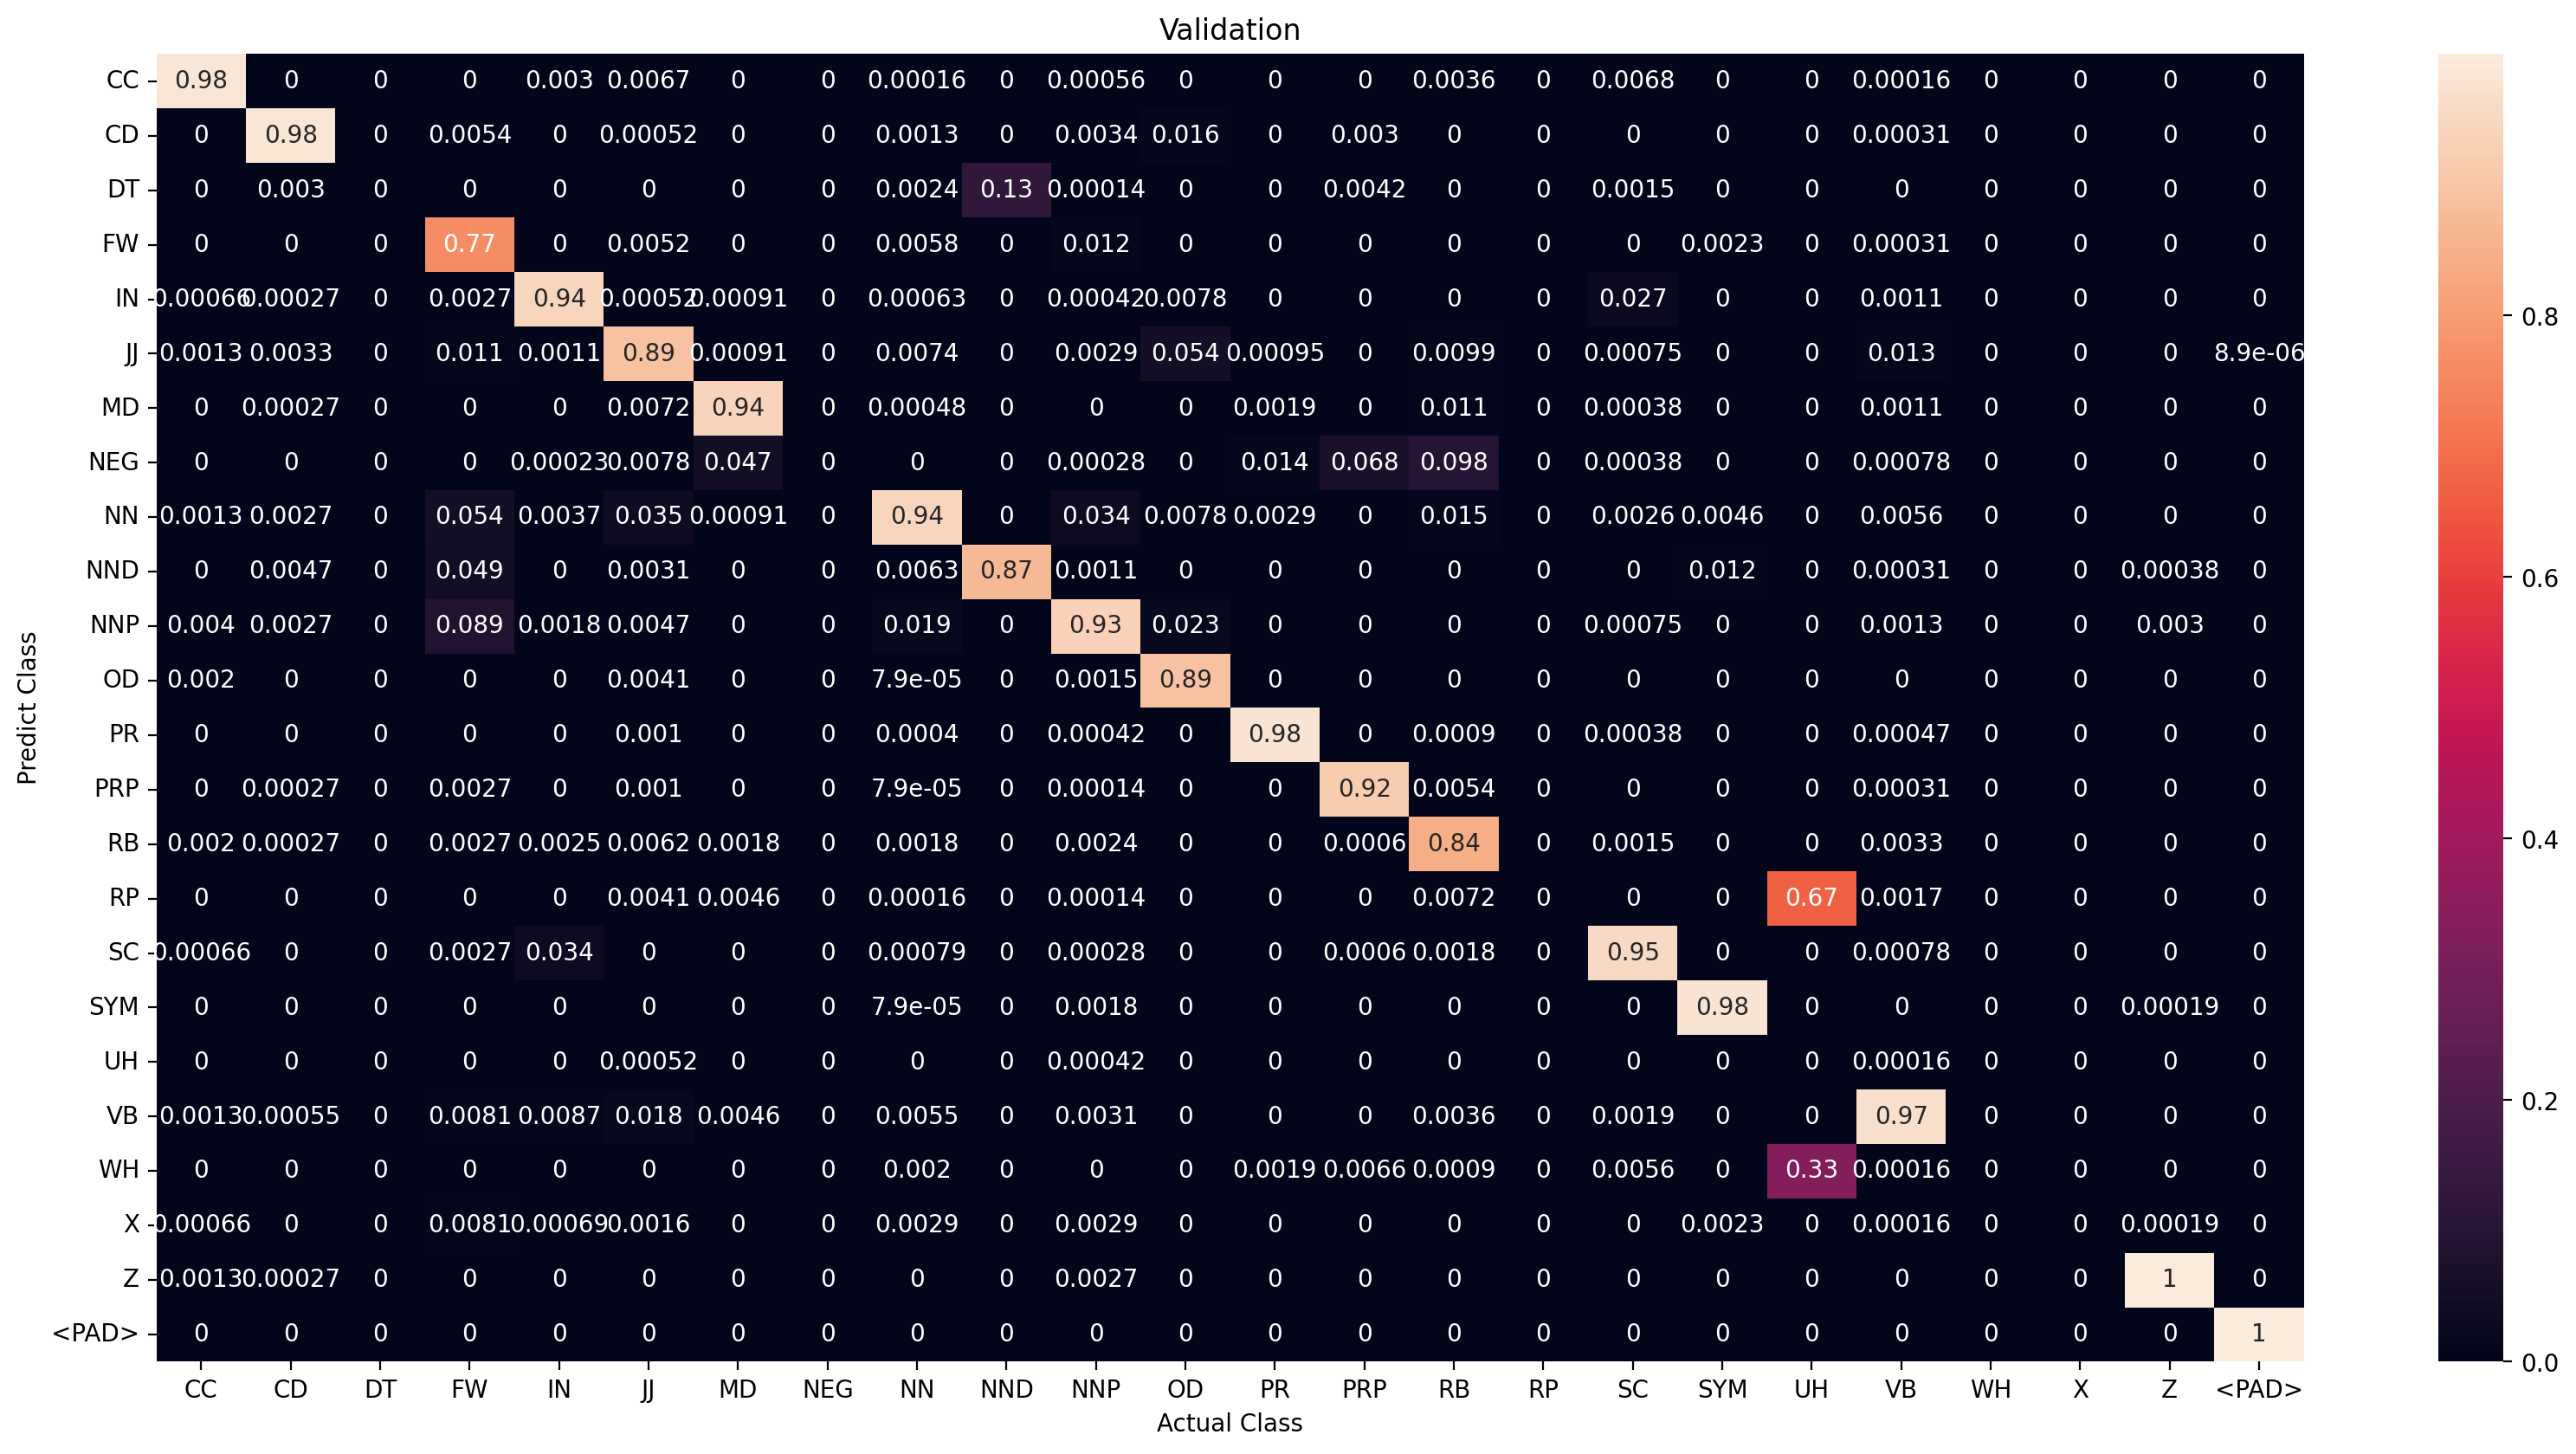

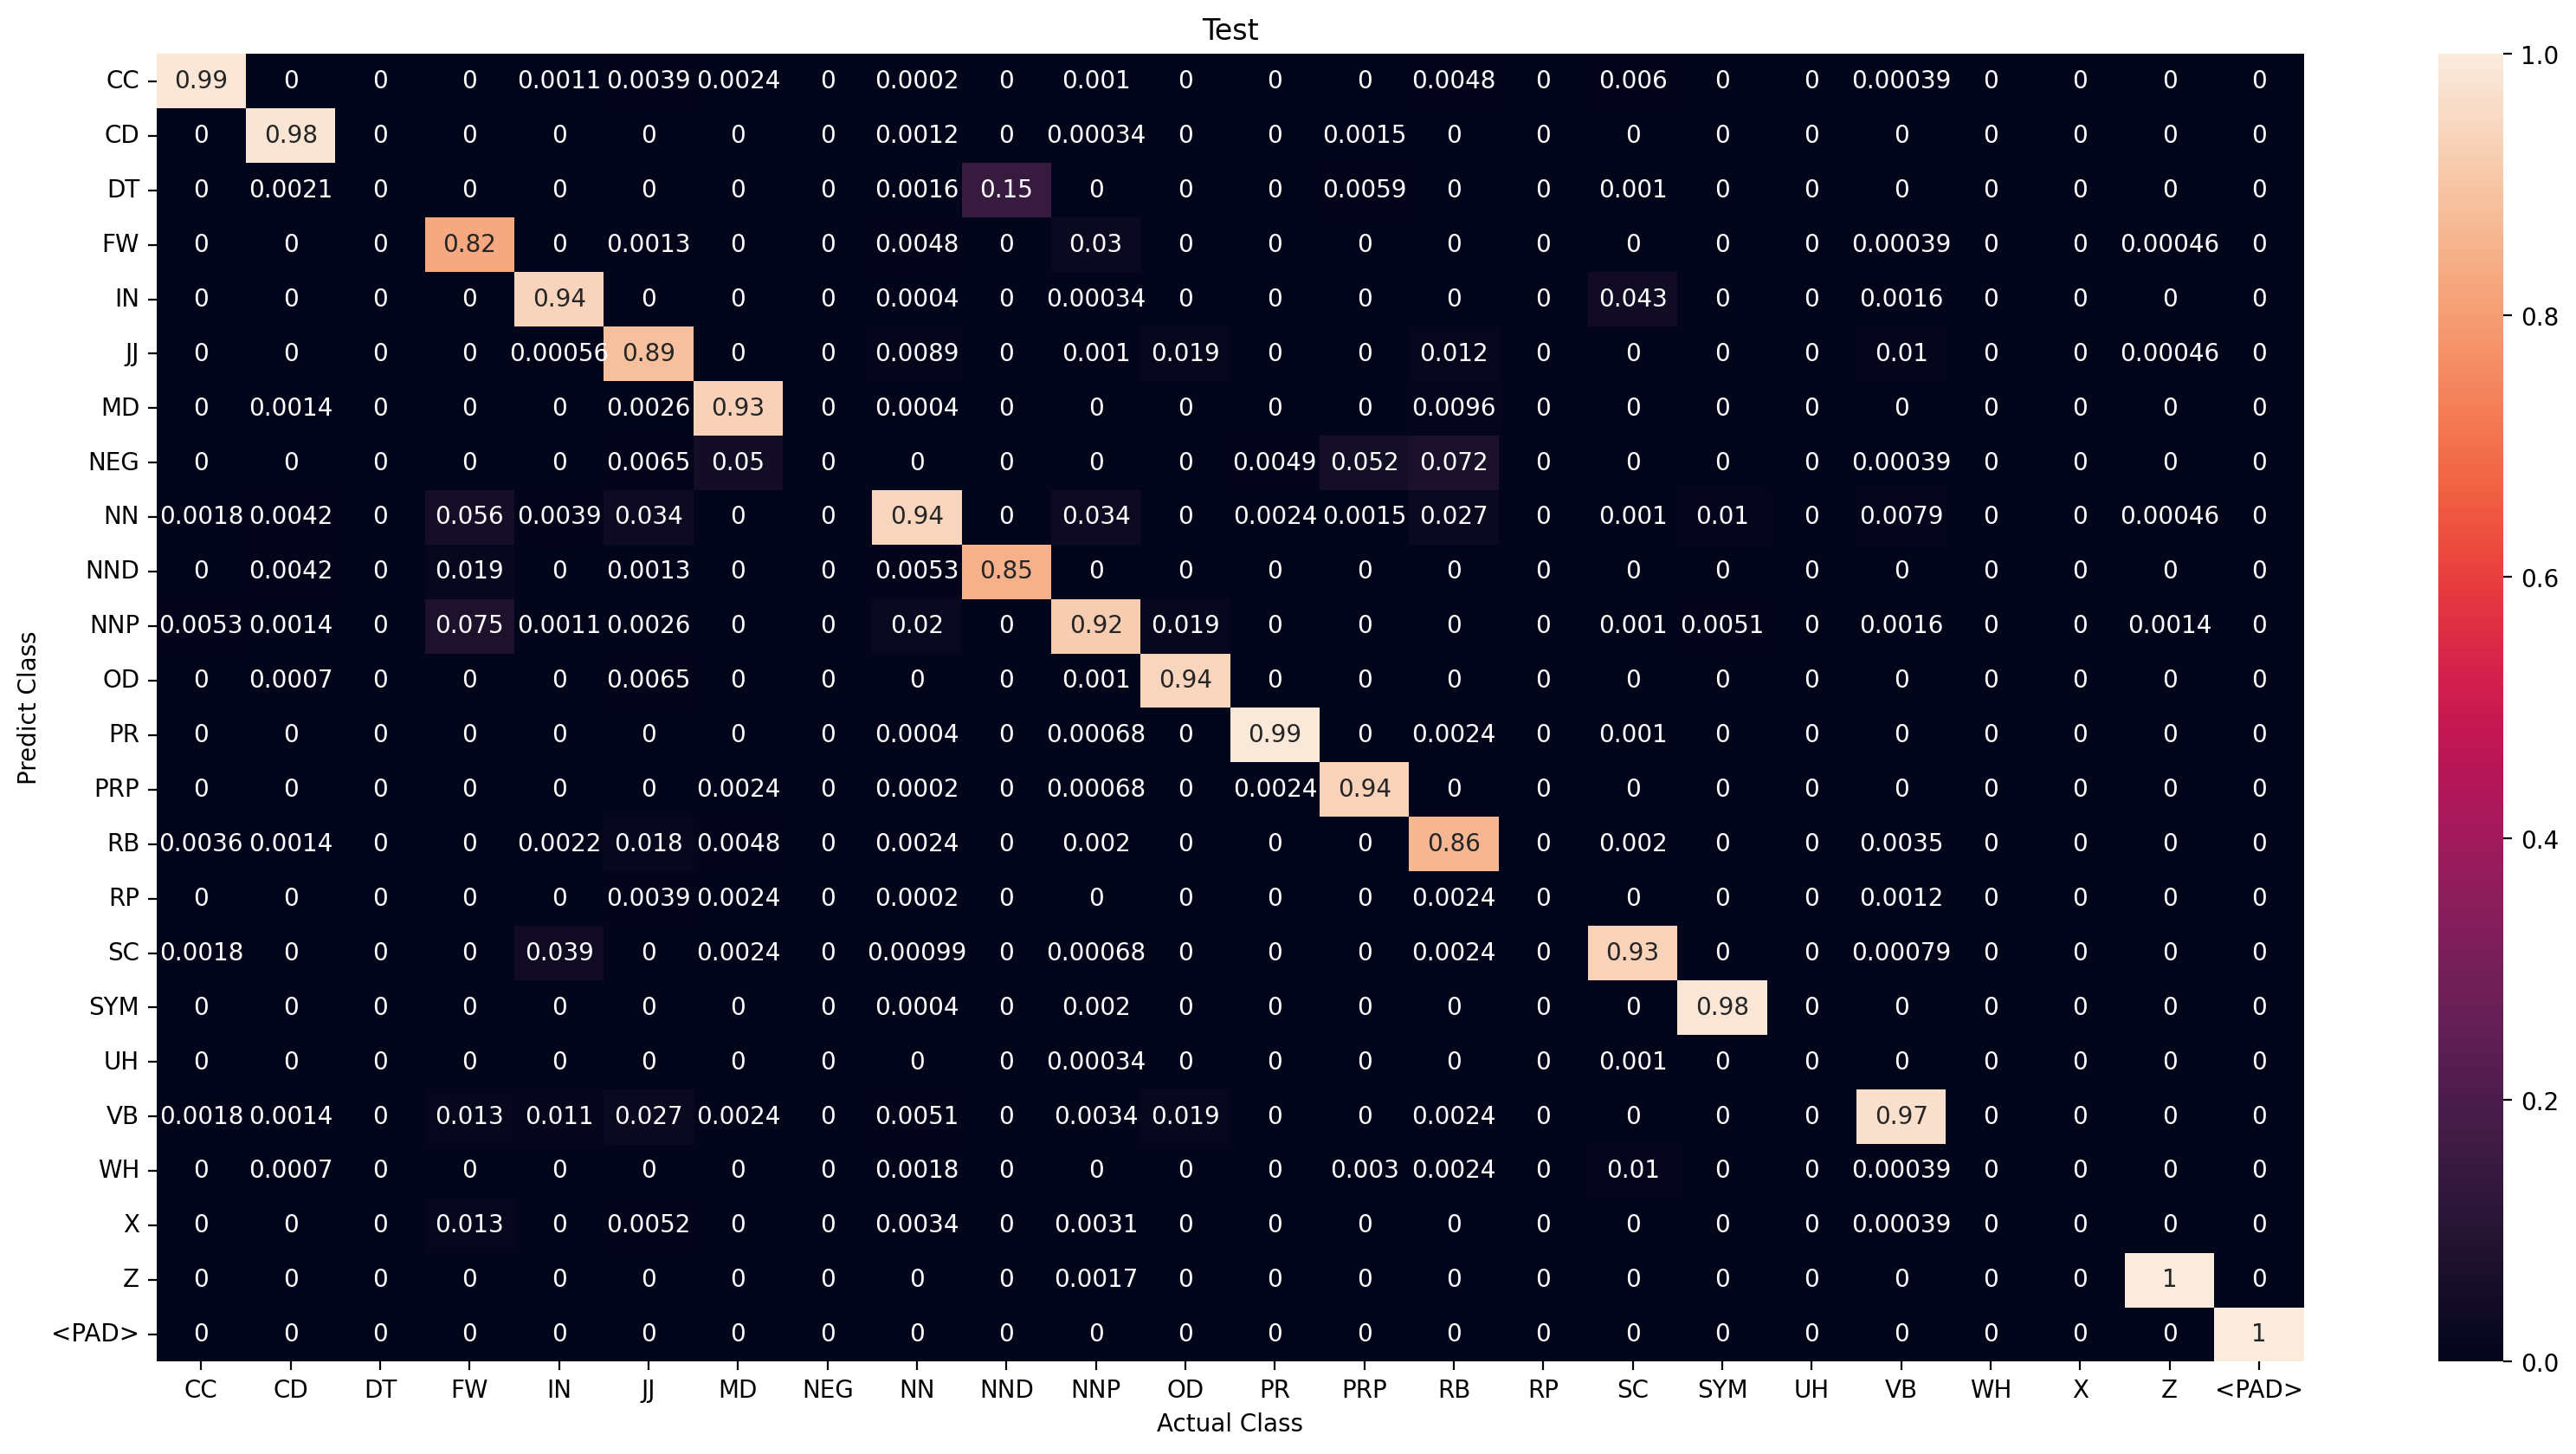

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5200       | CC    : 122      |
| CD    : 12758  | CD    : 12674      | CD    : 84       |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1428       | FW    : 238      |
| IN    : 15371  | IN    : 15247      | IN    : 124      |
| JJ    : 6997   | JJ    : 6572       | JJ    : 425      |
| MD    : 3774   | MD    : 3645       | MD    : 129      |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44146      | NN    : 526      |
| NND   : 1021   | NND   : 530        | NND   : 491      |
| NNP   : 24845  | NNP   : 24416      | NNP   : 429      |
| OD    : 541    | OD    : 515        | OD    : 26       |
| PR    : 3896   | PR    : 3848       | PR    : 48       |
| PRP   : 5408   | PRP   : 5370       | PRP   : 38       |
| RB    : 3463   | RB    : 3255       | RB    : 208      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11064
Wrong prediction            : 757
Percentage correct oov pred : 93.59614245833686

Validation
Number OOV token            : 3350
Correct prediction          : 2962
Wrong prediction            : 388
Percentage correct oov pred : 88.41791044776119

Test
Number OOV token            : 1391
Correct prediction          : 1230
Wrong prediction            : 161
Percentage correct oov pred : 88.4255930984903



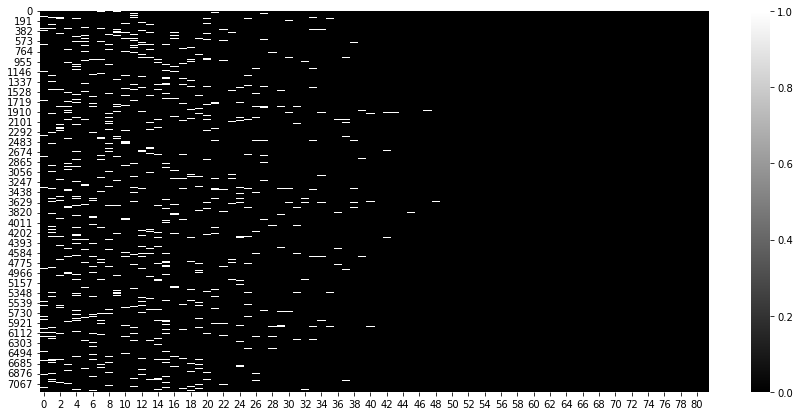

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

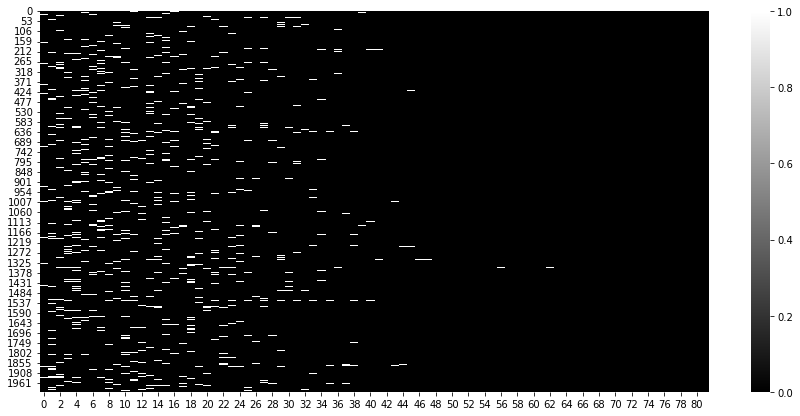

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

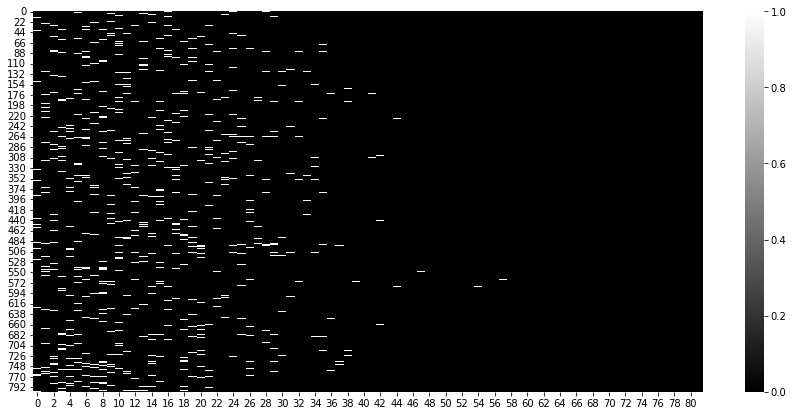

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);